In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics as stat

#specify parameters
a = 4.19
b = 0.0639
sigma = 1.71
mu = 0.0259

a_tilde = a + (sigma**2)/2
b_tilde = (2*a*b)/(2*a + sigma**2)

#specify the initial condition (Y is V)
U_0 = np.log(0.9335)
Y_0 = 0.0649

constants = {
    'a': a, 
    'b': b, 
    'vol': sigma, 
    'drift': mu,
    'a tilde': a_tilde, 
    'b tilde': b_tilde,
    'IV U': U_0,
    'IV V': Y_0
}


# BM generator

In [2]:
def BM(T, h):
#Define time discretization
    N = int(T/h)
    t = np.arange(0, T+h, h)

# Define the crude Brownian increments
    W_crude = np.zeros(N+1)
    dW_crude = np.zeros(N)
    W_crude[0]= 0
    for i in range(N):
        dW_crude[i] = np.random.normal(0, np.sqrt(h))
        W_crude[i+1] = W_crude[i] + dW_crude[i]

    BMoutputs = {
        'step size': h,
        'crude delta W': dW_crude
    }
    return BMoutputs

## Define refine function

In [3]:
def refine(dW, h):
    B = np.random.normal(0, np.sqrt(h/4))
    half_h = h/2
    dW_1 = dW/2 - B
    dW_2 = dW/2 + B
    
    return dW_1, dW_2, half_h

## Define the function to create fine steps for Milstein

In [4]:
def fine_step(y, u, constants, h, dWv, dWu, no_refines = 3):
    sigma = constants['vol']
    mu = constants['drift']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    if no_refines == 0:
        y_new = y + a_tilde*(b_tilde - y)*h + sigma*y*dWv + (1/2)*(sigma**2)*y*((dWv)**2)
        u_new = u + (mu - (1/2)*(y**2))*h + y*dWu + (1/2)*sigma*y*dWu*dWv
        return [y_new], [u_new], [dWv], [dWu]
    else:
        dWu_1, dWu_2, _ = refine(dWu, h)
        dWv_1, dWv_2, half_h_v = refine(dWv, h)
        y_new1, u_new1, dWv1 , dWu1= fine_step(y, u, constants, half_h_v, dWv_1, dWu_1, no_refines-1)
        y_new2, u_new2, dWv2, dWu2 = fine_step(y_new1[-1], u_new1[-1], constants, half_h_v, dWv_2, dWu_2, no_refines - 1)

        return y_new1 + y_new2, u_new1 + u_new2, dWv1 + dWv2, dWu1 + dWu2
    

# Define the function for adaptive Milstein method

In [5]:
def milstein_adapt_iga(y, u, constants, tol, h, dWv, dWu,):
    sigma = constants['vol']
    mu = constants['drift']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    c = tol

    y_new = y + a_tilde*(b_tilde - y)*h + sigma*y*dWv + (1/2)*(sigma**2)*y*((dWv)**2)
    if 0.5*(y+y_new) <= c/np.sqrt(h) or (h <= 1/256):
        u_new = u + (mu - (1/2)*(y**2))*h + y*dWu + (1/2)*sigma*y*dWu*dWv
        return [y_new], [u_new], [dWv], [dWu], [h]
    else:
        dWu_1, dWu_2, _ = refine(dWu, h)
        dWv_1, dWv_2, half_h_v = refine(dWv, h)
        y_new1, u_new1, dWv1 , dWu1, h1 = milstein_adapt_iga(y, u, constants, c, half_h_v, dWv_1, dWu_1)
        y_new2, u_new2, dWv2, dWu2, h2 = milstein_adapt_iga(y_new1[-1], u_new1[-1], constants, c, half_h_v, dWv_2, dWu_2)
        return y_new1 + y_new2, u_new1 + u_new2, dWv1 + dWv2, dWu1 + dWu2, h1 + h2


## Run the Milstein with adaptive step sizes for different tolerances 

In [6]:
T = 1
h_0 = 1/2 * T
u_0 = constants['IV U']
y_0 = constants['IV V']
no_samples = 10000
mean_errors = []
ave_no_steps = []
no_refines = 3
two_to_refines = 2**no_refines

for c in [1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024, 1/2048]:
    errors = []
    no_steps = []
    for i in tqdm(range(no_samples)):
        y_output = [y_0]
        u_output = [u_0]
        dWv_crude_output = [0]
        dWu_crude_output = [0]
        h_crude = [0]
        y_fine_output = [y_0]
        u_fine_output = [u_0]
        dWv_fine_output = [0]
        dWu_fine_output = [0]
        step_counter = 0
        BMoutputs_v = BM(T, h_0)
        dWv_crude = BMoutputs_v['crude delta W']
        h = BMoutputs_v['step size']
        BMoutputs_u = BM(T, h_0)
        dWu_crude = BMoutputs_u['crude delta W']
        for i in range(len(dWv_crude)):
            y, u, dWv_crude_adapt, dWu_crude_adapt, h_new = milstein_adapt_iga(y_output[-1], u_output[-1], constants, c, h, dWv_crude[i], dWu_crude[i])
            y_output.extend(y)
            u_output.extend(u)
            dWv_crude_output.extend(dWv_crude_adapt)
            dWu_crude_output.extend(dWu_crude_adapt)
            h_crude.extend(h_new)
            step_counter += len(dWv_crude_adapt)
        times = [sum(h_crude[0:i+1]) for i in range(len(h_crude))]
        for i in range(1,len(dWv_crude_output)):
            dWv = dWv_crude_output[i]
            dWu = dWu_crude_output[i]
            h = h_crude[i]
            y_fine, u_fine, dWv_fine, dWu_fine = fine_step(y_fine_output[-1], u_fine_output[-1], constants, h, dWv, dWu, no_refines)
            y_fine_output.extend(y_fine)
            u_fine_output.extend(u_fine)
            dWv_fine_output.extend(dWv_fine)
            dWu_fine_output.extend(dWu_fine)
        h_fine = [0]*(two_to_refines*(len(h_crude)-1)+1)
        for i in range(len(h_crude)-1):
            h_fine[(two_to_refines*i)+1:two_to_refines*(i+1)+1] = [h_crude[i+1]/two_to_refines]*(two_to_refines)
        times_fine = [sum(h_fine[0:i+1]) for i in range(len(h_fine))]
        E = (u_output[-1]-u_fine_output[-1])**2
        errors.append(E)
        no_steps.append(step_counter)
    mean_E = m.sqrt(stat.mean(errors))
    mean_errors.append(mean_E)
    ave_no_steps.append(stat.mean(no_steps))


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:40<00:00, 35.67it/s]


## Define the function to create fine steps for Heun's

In [7]:
def heun_fine_step(y, u, constants, h, dWv, dWu, no_refines = 3):
    sigma = constants['vol']
    mu = constants['drift']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    if no_refines == 0:
        y_tilde = y + a_tilde*(b_tilde - y)*h + sigma*y*dWv 
        y_new = y + (1/2)*h*(a_tilde*(b_tilde - y) + a_tilde*(b_tilde - y_tilde)) + (1/2)*(sigma*y + sigma*y_tilde)*dWv
        u_new = u + (mu - (1/4)*(y**2) - (1/4)*(y_tilde**2))*h + (1/2)*(y + y_tilde)*dWu
        return [y_new], [u_new], [dWv], [dWu]
    else:
        dWu_1, dWu_2, _ = refine(dWu, h)
        dWv_1, dWv_2, half_h_v = refine(dWv, h)
        y_new1, u_new1, dWv1 , dWu1= heun_fine_step(y, u, constants, half_h_v, dWv_1, dWu_1, no_refines - 1)
        y_new2, u_new2, dWv2, dWu2 = heun_fine_step(y_new1[-1], u_new1[-1], constants, half_h_v, dWv_2, dWu_2, no_refines - 1)

        return y_new1 + y_new2, u_new1 + u_new2, dWv1 + dWv2, dWu1 + dWu2

# Define the function for adaptive Heun's method

In [8]:
def heun_adapt_iga(y, u, constants, tol, h, dWv, dWu,):
    sigma = constants['vol']
    mu = constants['drift']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    c = tol

    y_tilde = y + a_tilde*(b_tilde - y)*h + sigma*y*dWv 
    y_new = y + (1/2)*h*(a_tilde*(b_tilde - y) + a_tilde*(b_tilde - y_tilde)) + (1/2)*(sigma*y + sigma*y_tilde)*dWv
    if 0.5*(y+y_new) <= c/np.sqrt(h) or (h <= 1/256):
        u_new = u + (mu - (1/4)*(y**2) - (1/4)*(y_tilde**2))*h + (1/2)*(y + y_tilde)*dWu
        return [y_new], [u_new], [dWv], [dWu], [h]
    else:
        dWu_1, dWu_2, _ = refine(dWu, h)
        dWv_1, dWv_2, half_h_v = refine(dWv, h)
        y_new1, u_new1, dWv1 , dWu1, h1 = heun_adapt_iga(y, u, constants, c, half_h_v, dWv_1, dWu_1)
        y_new2, u_new2, dWv2, dWu2, h2 = heun_adapt_iga(y_new1[-1], u_new1[-1], constants, c, half_h_v, dWv_2, dWu_2)
        return y_new1 + y_new2, u_new1 + u_new2, dWv1 + dWv2, dWu1 + dWu2, h1 + h2


## Run the Heun's method with adaptive step sizes for different tolerances 

In [9]:
T = 1
h_0 = 1/2 * T
u_0 = constants['IV U']
y_0 = constants['IV V']
no_samples = 10000
heun_mean_errors = []
heun_ave_no_steps = []
no_refines = 3
two_to_refines = 2**no_refines

for c in [1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024, 1/2048]:
    errors = []
    no_steps = []
    for i in tqdm(range(no_samples)):
        y_output = [y_0]
        u_output = [u_0]
        dWv_crude_output = [0]
        dWu_crude_output = [0]
        h_crude = [0]
        y_fine_output = [y_0]
        u_fine_output = [u_0]
        dWv_fine_output = [0]
        dWu_fine_output = [0]
        step_counter = 0
        BMoutputs_v = BM(T, h_0)
        dWv_crude = BMoutputs_v['crude delta W']
        h = BMoutputs_v['step size']
        BMoutputs_u = BM(T, h_0)
        dWu_crude = BMoutputs_u['crude delta W']
        for i in range(len(dWv_crude)):
            y, u, dWv_crude_adapt, dWu_crude_adapt, h_new = heun_adapt_iga(y_output[-1], u_output[-1], constants, c, h, dWv_crude[i], dWu_crude[i])
            y_output.extend(y)
            u_output.extend(u)
            dWv_crude_output.extend(dWv_crude_adapt)
            dWu_crude_output.extend(dWu_crude_adapt)
            h_crude.extend(h_new)
            step_counter += len(dWv_crude_adapt)
        times = [sum(h_crude[0:i+1]) for i in range(len(h_crude))]
        for i in range(1,len(dWv_crude_output)):
            dWv = dWv_crude_output[i]
            dWu = dWu_crude_output[i]
            h= h_crude[i]
            y_fine, u_fine, dWv_fine, dWu_fine = heun_fine_step(y_fine_output[-1], u_fine_output[-1], constants, h, dWv, dWu, no_refines)
            y_fine_output.extend(y_fine)
            u_fine_output.extend(u_fine)
            dWv_fine_output.extend(dWv_fine)
            dWu_fine_output.extend(dWu_fine)
        h_fine = [0]*(two_to_refines*(len(h_crude)-1)+1)
        for i in range(len(h_crude)-1):
            h_fine[(two_to_refines*i)+1:two_to_refines*(i+1)+1] = [h_crude[i+1]/two_to_refines]*(two_to_refines)
        times_fine = [sum(h_fine[0:i+1]) for i in range(len(h_fine))]
        E = (u_output[-1]-u_fine_output[-1])**2
        errors.append(E)
        no_steps.append(step_counter)
    mean_E = m.sqrt(stat.mean(errors))
    heun_mean_errors.append(mean_E)
    heun_ave_no_steps.append(stat.mean(no_steps))


100%|██████████| 10000/10000 [04:44<00:00, 35.18it/s]


## Plot error vs average number of steps for both methods

Milstein: 0.33498267687424477
Heun: 0.5051445649757192


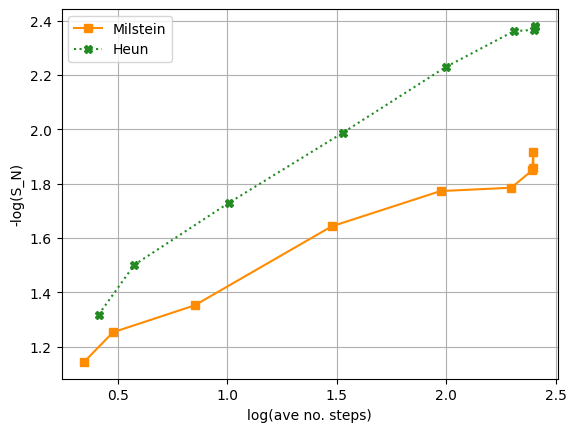

In [10]:
from scipy.stats import linregress
mil_log_steps = [m.log10(x) for x in ave_no_steps]
mil_log_errors = [-m.log10(x) for x in mean_errors]
heun_log_steps = [m.log10(x) for x in heun_ave_no_steps]
heun_log_errors = [-m.log10(x) for x in heun_mean_errors]
plt.plot(mil_log_steps, mil_log_errors, label='Milstein',linestyle='-', marker="s", color='darkorange')
plt.plot(heun_log_steps, heun_log_errors, label='Heun', linestyle='dotted', marker="X", color='forestgreen')
plt.xlabel('log(ave no. steps)')
plt.ylabel('-log(S_N)')
plt.legend()
plt.grid(True)
slope_mil, intercept_mil, _, _, _ = linregress(mil_log_steps, mil_log_errors)
slope_heun, intercept_heun, _, _, _ = linregress(heun_log_steps, heun_log_errors)
print("Milstein:", slope_mil)
print("Heun:", slope_heun)